# How to size your bets - The Kelly Rule

The Kelly rule has a long history in gambling because it provides guidance on how much to stake on each of an (infinite) sequence of bets with varying (but favorable) odds to maximize terminal wealth. It was published as A New Interpretation of the Information Rate in 1956 by John Kelly who was a colleague of Claude Shannon's at Bell Labs. He was intrigued by bets placed on candidates at the new quiz show The $64,000 Question, where a viewer on the west coast used the three-hour delay to obtain insider information about the winners. 

Kelly drew a connection to Shannon's information theory to solve for the bet that is optimal for long-term capital growth when the odds are favorable, but uncertainty remains. His rule maximizes logarithmic wealth as a function of the odds of success of each game, and includes implicit bankruptcy protection since log(0) is negative infinity so that a Kelly gambler would naturally avoid losing everything.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
from pathlib import Path

import numpy as np
from numpy.linalg import inv
from numpy.random import dirichlet
import pandas as pd

from sympy import symbols, solve, log, diff
from scipy.optimize import minimize_scalar, newton, minimize
from scipy.integrate import quad
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
DATA_STORE = Path('..', 'data', 'assets.h5')

## The optimal size of a bet

Kelly began by analyzing games with a binary win-lose outcome. The key variables are:
- b: The odds define the amount won for a \\$1 bet. Odds = 5/1 implies a \\$5 gain if the bet wins, plus recovery of the \\$1 capital.
- p: The probability defines the likelihood of a favorable outcome.
- f: The share of the current capital to bet.
- V: The value of the capital as a result of betting.

The Kelly rule aims to maximize the value's growth rate, G, of infinitely-repeated bets (see Chapter 5 for background).
$$G=\lim_{N\rightarrow\infty}=\frac{1}{N}\log\frac{V_N}{V_0}$$

We can maximize the rate of growth G by maximizing G with respect to f, as illustrated using sympy as follows:

In [6]:
share, odds, probability = symbols('share odds probability')
Value = probability * log(1 + odds * share) + (1 - probability) * log(1 - share)
solve(diff(Value, share), share)

[(odds*probability + probability - 1)/odds]

In [7]:
f, p = symbols('f p')
y = p * log(1 + f) + (1 - p) * log(1 - f)
solve(diff(y, f), f)

[2*p - 1]

## Get S&P 500 Data

In [49]:
with pd.HDFStore(DATA_STORE) as store:
    sp500 = store['sp500/fred'].close
    # sp500 = store['sp500/stooq'].close

### Compute Returns & Standard Deviation

In [50]:
annual_returns = sp500.resample('A').last().pct_change().dropna().to_frame('sp500')

In [51]:
return_params = annual_returns.sp500.rolling(5).agg(['mean', 'std']).dropna() # switched from rolling 25 to 5 due to lack of data

In [52]:
return_ci = (return_params[['mean']]
                .assign(lower=return_params['mean'].sub(return_params['std'].mul(2)))
                .assign(upper=return_params['mean'].add(return_params['std'].mul(2))))

In [53]:
return_ci

,mean,lower,upper
DATE,,,
2018-12-31,0.066764,-0.136795,0.270322
2019-12-31,0.101738,-0.185297,0.388773
2020-12-31,0.135709,-0.125901,0.397319
2021-12-31,0.170425,-0.109811,0.450661
2022-12-31,0.092699,-0.332599,0.517997
2023-12-31,0.114460,-0.281273,0.510192


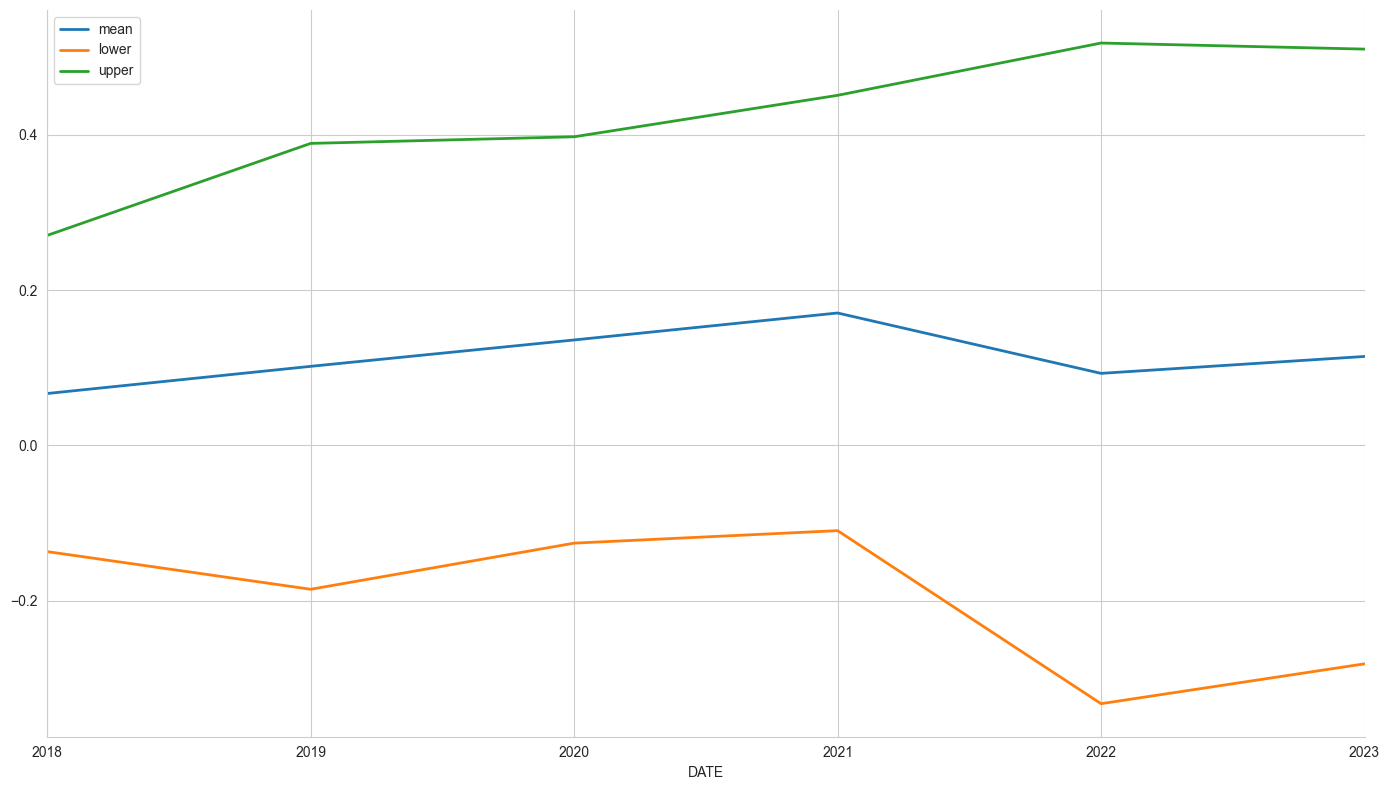

In [54]:
return_ci.plot(lw=2, figsize=(14, 8))
plt.tight_layout()
sns.despine();

### Kelly Rule for a Single Asset - Index Returns

In a financial market context, both outcomes and alternatives are more complex, but the Kelly rule logic does still apply. It was made popular by Ed Thorp, who first applied it profitably to gambling (described in Beat the Dealer) and later started the successful hedge fund Princeton/Newport Partners.

With continuous outcomes, the growth rate of capital is defined by an integrate over the probability distribution of the different returns that can be optimized numerically.
We can solve this expression (see book) for the optimal f* using the `scipy.optimize` module:

In [55]:
def norm_integral(f, mean, std):
    val, er = quad(lambda s: np.log(1 + f * s) * norm.pdf(s, mean, std), 
                               mean - 3 * std, 
                               mean + 3 * std)
    return -val

In [56]:
def norm_dev_integral(f, mean, std):
    val, er = quad(lambda s: (s / (1 + f * s)) * norm.pdf(s, mean, std), m-3*std, mean+3*std)
    return val

In [57]:
def get_kelly_share(data):
    solution = minimize_scalar(norm_integral, 
                        args=(data['mean'], data['std']), 
                        bounds=[0, 2], 
                        method='bounded') 
    return solution.x

In [58]:
annual_returns['f'] = return_params.apply(get_kelly_share, axis=1)

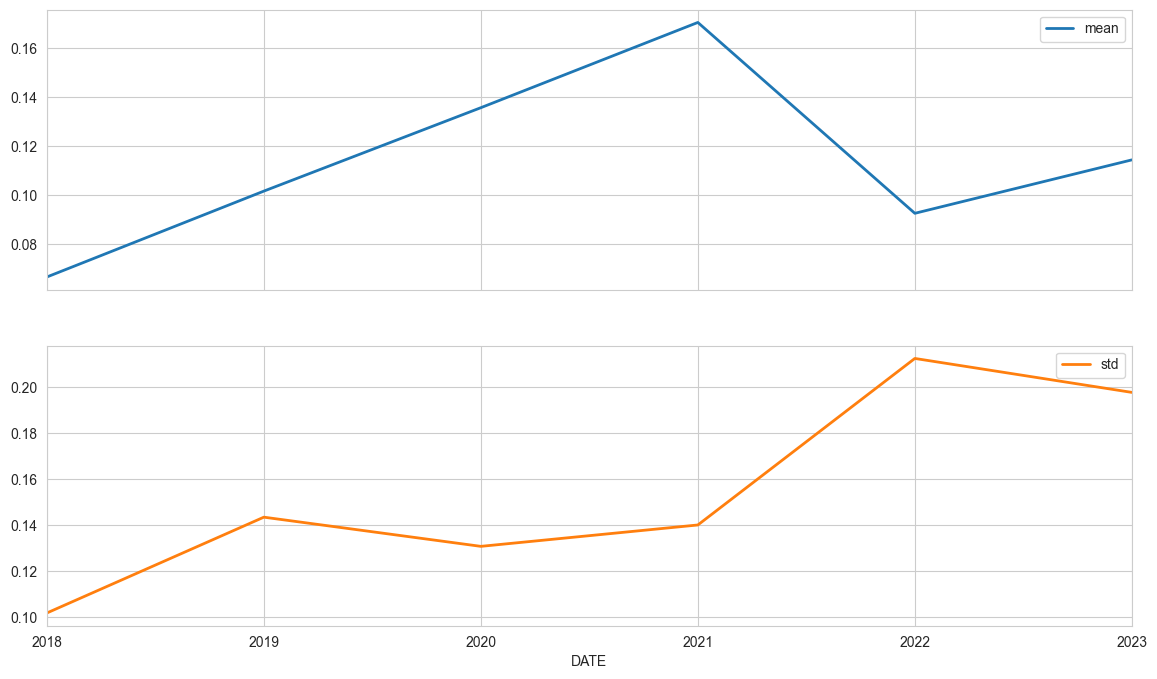

In [59]:
return_params.plot(subplots=True, lw=2, figsize=(14, 8));

In [60]:
annual_returns.tail()

,sp500,f
DATE,,
2019-12-31,0.288781,1.999996
2020-12-31,0.162589,1.999996
2021-12-31,0.268927,1.999996
2022-12-31,-0.194428,1.744057
2023-12-31,0.046431,1.999996


### Performance Evaluation

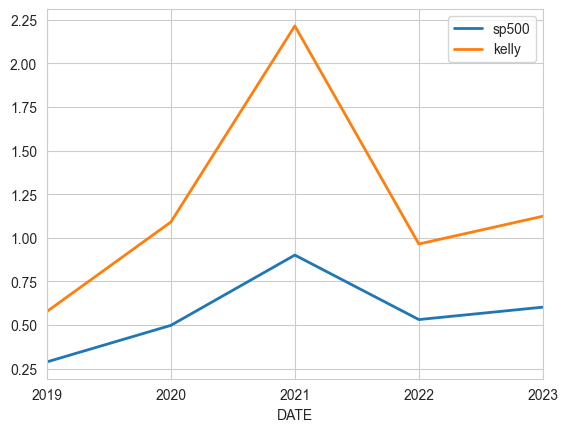

In [61]:
(annual_returns[['sp500']]
 .assign(kelly=annual_returns.sp500.mul(annual_returns.f.shift()))
 .dropna()
 .loc['1900':]
 .add(1)
 .cumprod()
 .sub(1)
 .plot(lw=2));


In [62]:
annual_returns.f.describe()

count    6.000000
mean     1.957339
std      0.104487
min      1.744057
25%      1.999996
50%      1.999996
75%      1.999996
max      1.999996
Name: f, dtype: float64

In [63]:
return_ci.head()

,mean,lower,upper
DATE,,,
2018-12-31,0.066764,-0.136795,0.270322
2019-12-31,0.101738,-0.185297,0.388773
2020-12-31,0.135709,-0.125901,0.397319
2021-12-31,0.170425,-0.109811,0.450661
2022-12-31,0.092699,-0.332599,0.517997


### Compute Kelly Fraction

In [64]:
m = .058
s = .216

In [65]:
# Option 1: minimize the expectation integral
sol = minimize_scalar(norm_integral, args=(m, s), bounds=[0., 2.], method='bounded')
print('Optimal Kelly fraction: {:.4f}'.format(sol.x))

Optimal Kelly fraction: 1.1974


In [66]:
# Option 2: take the derivative of the expectation and make it null
x0 = newton(norm_dev_integral, .1, args=(m, s))
print('Optimal Kelly fraction: {:.4f}'.format(x0))

Optimal Kelly fraction: 1.1974


## Kelly Rule for Multiple Assets

We will use an example with various equities. [E. Chan (2008)](https://www.amazon.com/Quantitative-Trading-Build-Algorithmic-Business/dp/0470284889) illustrates how to arrive at a multi-asset application of the Kelly Rule, and that the result is equivalent to the (potentially levered) maximum Sharpe ratio portfolio from the mean-variance optimization. 

The computation involves the dot product of the precision matrix, which is the inverse of the covariance matrix, and the return matrix:

In [67]:
with pd.HDFStore(DATA_STORE) as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks)

In [68]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Columns: 457 entries, MMM to ZTS
dtypes: float64(457)
memory usage: 49.9 MB


In [69]:
monthly_returns = prices.loc['1988':'2017'].resample('M').last().pct_change().dropna(how='all').dropna(axis=1)
stocks = monthly_returns.columns
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Columns: 193 entries, MMM to XEL
dtypes: float64(193)
memory usage: 544.1 KB


### Compute Precision Matrix

In [70]:
cov = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov), index=stocks, columns=stocks)

In [71]:
kelly_allocation = monthly_returns.mean().dot(precision_matrix)

In [72]:
kelly_allocation.describe()

count    193.000000
mean       0.252466
std        3.376205
min       -9.583007
25%       -1.712525
50%        0.216006
75%        2.136321
max        9.562480
dtype: float64

In [73]:
kelly_allocation.sum()

48.72589009062715

### Largest Portfolio Allocation

The plot shows the tickers that receive an allocation weight > 5x their value:

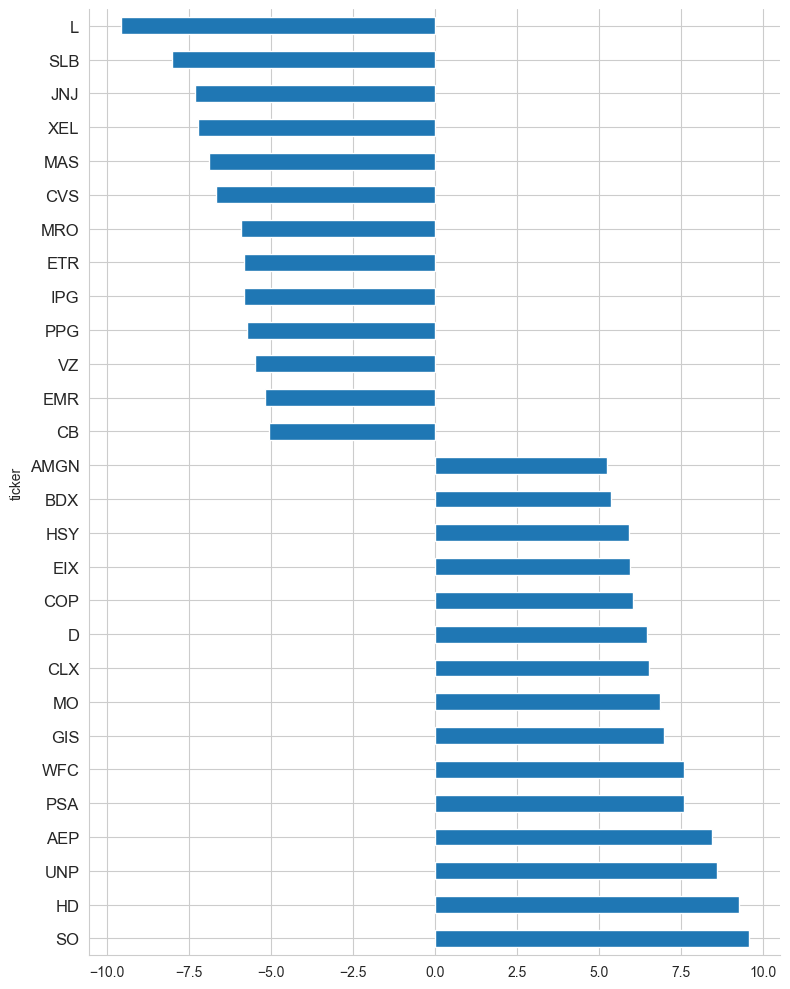

In [74]:
kelly_allocation[kelly_allocation.abs()>5].sort_values(ascending=False).plot.barh(figsize=(8, 10))
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout();

### Performance vs SP500

The Kelly rule does really well. But it has also been computed from historical data..

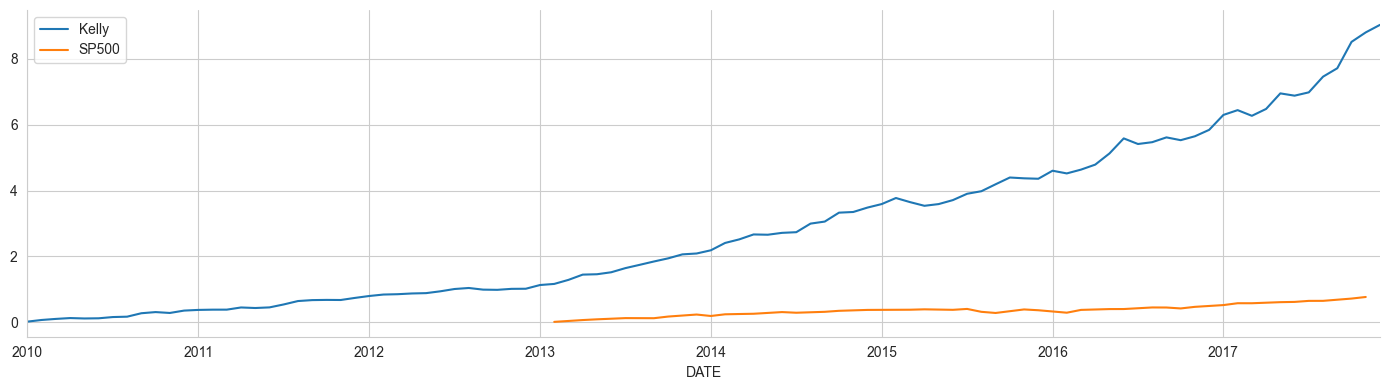

In [75]:
ax = monthly_returns.loc['2010':].mul(kelly_allocation.div(kelly_allocation.sum())).sum(1).to_frame('Kelly').add(1).cumprod().sub(1).plot(figsize=(14,4));
sp500.filter(monthly_returns.loc['2010':].index).pct_change().add(1).cumprod().sub(1).to_frame('SP500').plot(ax=ax, legend=True)
plt.tight_layout()
sns.despine();